In [ ]:
#Using crank nicholson method for PUT option
#simplified equation (u_i)^n+1 =(u_i)^n + (alpha*dt/(2* (dS^2))) * [(u_i+1)^n - 2*(u_i)^n +(u_i-1)^n + (u_i+1)^n+1 - 2*(u_i+1)^n

In [10]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt

In [11]:
K=100
r=0.05
sigma=0.25
S_min = K/5
S_max = K*2
N_S=10 #number of steps for S(asset) to create dS
N_t=10 #number of time steps to create dt
expiration=1

dS = (S_max-S_min)/N_S #creating dS 
dt = expiration/N_t

#populate S and V(option) matrices
S = np.arange(0, N_S+1)* dS +S_min #these are simply the steps of 20 to 200
V = np.zeros((N_S + 1, N_t + 1)) # these are populated at zeroes

print(S)
print(V)



[ 20.  38.  56.  74.  92. 110. 128. 146. 164. 182. 200.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [12]:
payoff = np.maximum((K-S), 0) #design payoff as strike-asset price for PUT option

#setting boundary conditions
V[:, -1] = payoff 
V[-1, :] = 0


V[0, :] = np.maximum(K - S_min, 0) * np.exp(-r * np.linspace(0, expiration, N_t + 1)[::-1]) #first 




In [13]:
I = np.arange(0,N_S+1)

alpha = 0.25 * dt * ((sigma**2) * (I**2) - r*I)
beta = -dt * 0.5 * (sigma**2 * (I**2) + r)
gamma = 0.25 * dt * (sigma**2 * (I**2) + r * I)
print(alpha,"\n")
print(beta,"\n")
print(gamma,"\n")

[0.        0.0003125 0.00375   0.0103125 0.02      0.0328125 0.04875
 0.0678125 0.09      0.1153125 0.14375  ] 

[-0.0025   -0.005625 -0.015    -0.030625 -0.0525   -0.080625 -0.115
 -0.155625 -0.2025   -0.255625 -0.315   ] 

[0.        0.0028125 0.00875   0.0178125 0.03      0.0453125 0.06375
 0.0853125 0.11      0.1378125 0.16875  ] 



In [14]:
ML = sparse.diags([-alpha[2:], 1-beta[1:], -gamma[1:]], [-1,0,1], shape=(N_S-1, N_S-1)).tocsc()
MR = sparse.diags([alpha[2:], 1+beta[1:], gamma[1:]], [-1,0,1],shape=(N_S-1, N_S-1)).tocsc()

print(ML)

  (1, 0)	-0.00375
  (0, 0)	1.005625
  (2, 1)	-0.0103125
  (1, 1)	1.015
  (0, 1)	-0.0028125000000000003
  (3, 2)	-0.020000000000000004
  (2, 2)	1.030625
  (1, 2)	-0.008749999999999999
  (4, 3)	-0.0328125
  (3, 3)	1.0525
  (2, 3)	-0.017812500000000002
  (5, 4)	-0.04875
  (4, 4)	1.080625
  (3, 4)	-0.03
  (6, 5)	-0.0678125
  (5, 5)	1.115
  (4, 5)	-0.045312500000000006
  (7, 6)	-0.09000000000000001
  (6, 6)	1.1556250000000001
  (5, 6)	-0.06375
  (8, 7)	-0.1153125
  (7, 7)	1.2025000000000001
  (6, 7)	-0.08531250000000001
  (8, 8)	1.255625
  (7, 8)	-0.11000000000000001


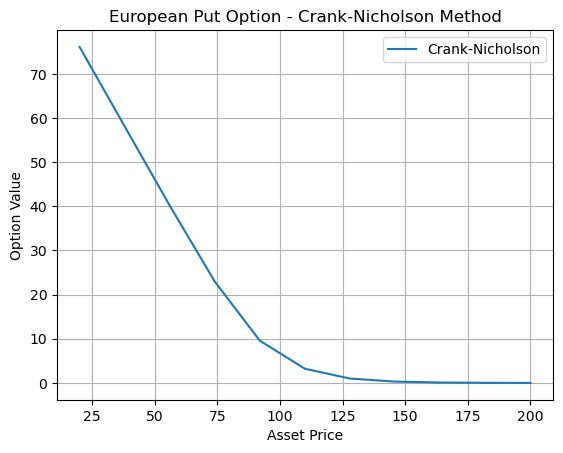

Asset Prices (S): [ 20.  38.  56.  74.  92. 110. 128. 146. 164. 182. 200.]
Option Values (V): [7.60983540e+01 5.80990484e+01 4.01461777e+01 2.29249188e+01
 9.54569211e+00 3.19696577e+00 9.85090979e-01 2.96659688e-01
 8.93022080e-02 2.51418079e-02 0.00000000e+00]


In [6]:
for t in range(N_t - 1, -1, -1):
    boundary_t = np.zeros(N_S - 1)
    boundary_t[0] = alpha[1] * (V[0, t] + V[0, t + 1]) -alpha[0] * V[0, t + 1]
    boundary_t[-1] = gamma[N_S - 1] * (V[N_S, t] + V[N_S, t + 1])
    b = MR.dot(V[1:N_S, t + 1]) + boundary_t
    V[1:N_S, t] = spsolve(ML, b)
plt.plot(S, V[:, 0], label='Crank-Nicholson')
plt.xlabel('Asset Price')
plt.ylabel('Option Value')
plt.title('European Put Option - Crank-Nicholson Method')
plt.legend()
plt.grid(True)
plt.show()

# Print the final V to debug plotting
print("Asset Prices (S):", S)
print("Option Values (V):", V[:, 0])